# Eval and visualisation (EuroSAT) 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torchvision.transforms as transforms
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from torch.utils.data import DataLoader

from vilu.models.clip import load as load_clip
from vilu.models.clip import tokenize as clip_tokenize
from vilu.models import viluAttention
from vilu.dataset_uq.utils import ConvertImageToRGB  
from vilu.dataset_uq import EuroSATDataset
import vilu.lib as lib





## Loading backbone dataset and uncertainties model

In [2]:
lvu_path = '../weights/lvu_eurosat.ckpt'
vilu_path = '../weights/vilu_eurosat.ckpt'
visu_path = '../visu/eurosat'
os.makedirs(visu_path,exist_ok=True)
dataset = 'EuroSAT'


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model, _ = load_clip("ViT-B/32")
clip_model.to(device)
print('CLIP model loaded')

CLIP model loaded


In [4]:
val_transforms = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.CenterCrop(224),
    ConvertImageToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])
dts_val = EuroSATDataset('../data/EuroSAT_RGB',split='test',transform=val_transforms)
dataloader_val = DataLoader(dts_val, batch_size=128, shuffle=False, num_workers=4)

In [5]:

lvu = viluAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        use_predicted_caption=False,
                                        use_attention=False,
                                        )

vilu = viluAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        use_predicted_caption=True,
                                        use_attention=True,
                                        )


template = "A photo of a {}."
logit_scale = vilu.logit_scale

In [6]:
lvu.load_state_dict(torch.load(lvu_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
vilu.load_state_dict(torch.load(vilu_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
lvu.to(device)
vilu.to(device)
lvu.eval()
vilu.eval()
print('Models loaded')

Models loaded


## Evaluate pretrain LuMen model

In [7]:
lvu_success = []
lvu_failure = []
vilu_success = []
vilu_failure = []
missclassifieds = []
tcps_success = []
tcps_failure = []
mcps_success = []
mcps_failure = []
total_iter = 0
with torch.no_grad():
    class_names = dataloader_val.dataset.class_names
    class_names = clip_tokenize([template.format(name) for name in class_names])
    for i, batch in enumerate(dataloader_val):
        images = batch["image"]
        labels = batch["target"].to(device)
        visual_feats = clip_model.encode_image(images.to(device))
        visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
        
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)

        probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
        with torch.autocast(device_type='cuda'):
            lvu_scores = lvu(visual_feats, text_feats).squeeze(-1)
            vilu_scores = vilu(visual_feats, text_feats).squeeze(-1)

        missclassified = labels != probs.argmax(dim=-1)

        tcps = probs[torch.arange(labels.size(0)), labels]
        mcps = probs.max(dim=-1).values

        lvu_success.append(lvu_scores[~missclassified])
        lvu_failure.append(lvu_scores[missclassified])
        vilu_success.append(vilu_scores[~missclassified])
        vilu_failure.append(vilu_scores[missclassified])
        missclassifieds.append(missclassified)
        mcps_success.append(mcps[~missclassified])
        mcps_failure.append(mcps[missclassified])
    
    missclassifieds = torch.cat(missclassifieds).cpu().numpy()
    lvu_success_sigmoid = torch.sigmoid(torch.cat(lvu_success)).cpu().numpy()
    lvu_failure_sigmoid = torch.sigmoid(torch.cat(lvu_failure)).cpu().numpy()
    vilu_success_sigmoid = torch.sigmoid(torch.cat(vilu_success)).cpu().numpy()
    vilu_failure_sigmoid = torch.sigmoid(torch.cat(vilu_failure)).cpu().numpy()
    lvu_success = torch.cat(lvu_success).cpu().numpy()
    lvu_failure = torch.cat(lvu_failure).cpu().numpy()
    vilu_success = torch.cat(vilu_success).cpu().numpy()
    vilu_failure = torch.cat(vilu_failure).cpu().numpy()
    mcps_success = torch.cat(mcps_success).float().cpu().numpy()
    mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

    fpr_lvu = lib.get_fpr(lvu_success, lvu_failure)
    auc_lvu = lib.get_auroc(lvu_success, lvu_failure)

    fpr_vilu = lib.get_fpr(vilu_success, vilu_failure)
    auc_vilu = lib.get_auroc(vilu_success, vilu_failure)

    fpr_mcm = lib.get_fpr(mcps_success, mcps_failure)
    auc_mcm = lib.get_auroc(mcps_success, mcps_failure)


In [8]:
print(f"AUC MCM: {auc_mcm:.4f}")
print(f"FPR MCM: {fpr_mcm:.4f}")
print(f"AUC LVU: {auc_lvu:.4f}")
print(f"FPR LVU: {fpr_lvu:.4f}")
print(f"AUC vilu: {auc_vilu:.4f}")
print(f"FPR vilu: {fpr_vilu:.4f}")

AUC MCM: 0.6570
FPR MCM: 0.8305
AUC LVU: 0.9570
FPR LVU: 0.2131
AUC vilu: 0.9883
FPR vilu: 0.0447


## Uncertainty score distribution

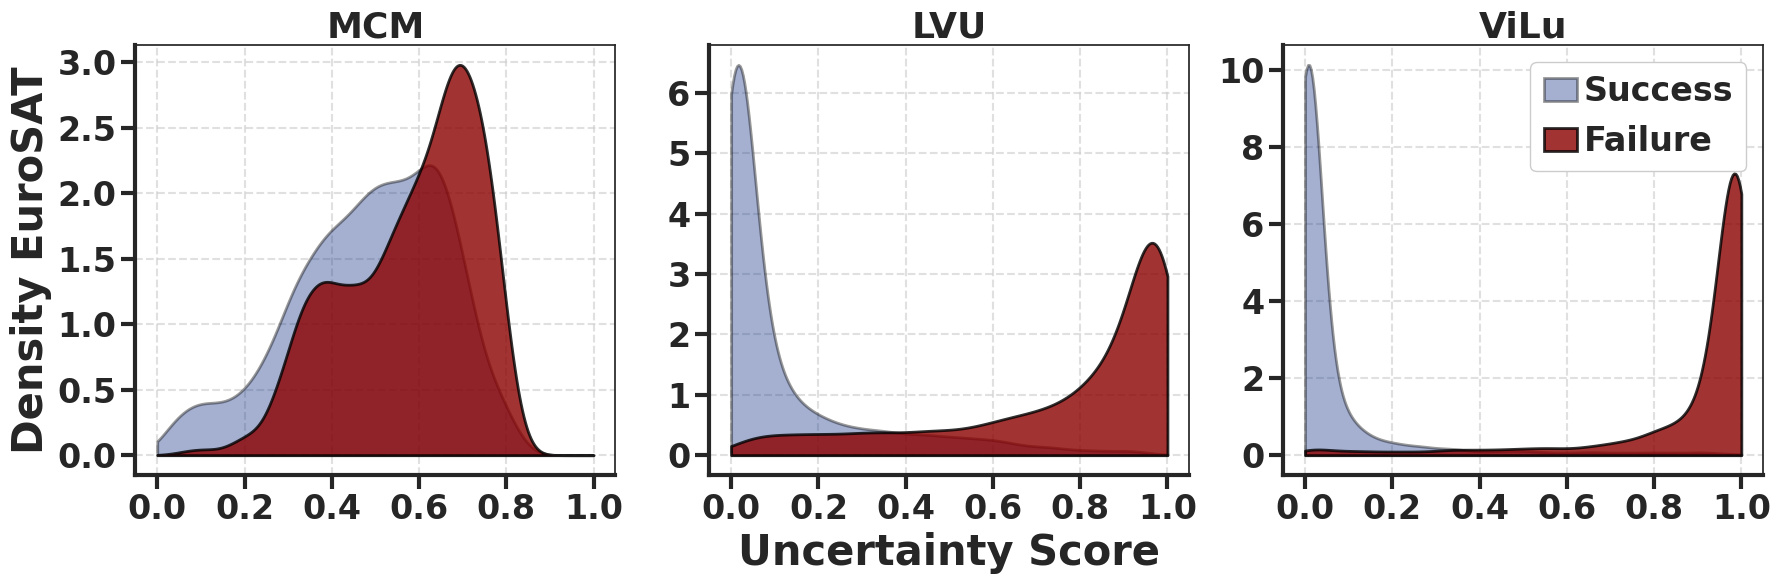

In [9]:

def plot_gaussian_distributions(mcps_success, mcps_failure, 
                                lvu_success, lvu_failure, 
                                vilu_success, vilu_failure):


    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 24  
    plt.rcParams['xtick.labelsize'] = 26  
    plt.rcParams['ytick.labelsize'] = 26  
    sns.set_theme(style="ticks")


    success_color = "#1E3A8A"  
    failure_color = "#8B0000"  

    methods = [
        (mcps_success, mcps_failure, "MCM"),
        (lvu_success, lvu_failure, "LVU"),
        (vilu_success, vilu_failure, "ViLu")
    ]
    
    plt.figure(figsize=(18, 6))

    for i, (success, failure, method) in enumerate(methods):
        plt.subplot(1, 3, i + 1)


        success_kde = gaussian_kde(success)
        failure_kde = gaussian_kde(failure)

        x_vals = np.linspace(0, 1, 300)

        success_density = success_kde(x_vals)
        failure_density = failure_kde(x_vals)

        plt.fill_between(x_vals, success_density, color=success_color, alpha=0.4, 
                         edgecolor='black', linewidth=2, label="Success")
        plt.fill_between(x_vals, failure_density, color=failure_color, alpha=0.8, 
                         edgecolor='black', linewidth=2, label="Failure")

        plt.title(f"{method}", fontsize=26, fontweight='bold')

        if i == 1:
            plt.xlabel("Uncertainty Score", fontsize=30, fontweight='bold')
        if i == 0:  
            plt.ylabel("Density "+dataset, fontsize=30, fontweight='bold')

        ax = plt.gca()
        ax.spines['bottom'].set_linewidth(3)  
        ax.spines['left'].set_linewidth(3)    
        ax.tick_params(axis='x', which='major', width=3, length=10) 
        ax.tick_params(axis='y', which='major', width=3, length=10)  
        
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(24)

        plt.grid(True, linestyle="--", linewidth=1.5, alpha=0.6)

    plt.legend(fontsize=24, loc='upper right', framealpha=1, handletextpad=0.2, 
               columnspacing=0.4, handlelength=1)

    plt.tight_layout()
    save_path = f"{visu_path}/failure_{dataset}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_gaussian_distributions(1 - mcps_success, 1 - mcps_failure, 1 - lvu_success_sigmoid, 1 - lvu_failure_sigmoid, 1 - vilu_success_sigmoid, 1 - vilu_failure_sigmoid)
